<a href="https://colab.research.google.com/github/MathewS424/PyTorch-Tutorial/blob/main/22_CNN_Implementation_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART 4**

# **IMPLEMENTATION OF CNNs**

In [1]:
#Load libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
#Device will determine whether to run the training on gpu or cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [4]:
# Import CIFAR-10 dataset from huggingFace
from datasets import load_dataset

dataset_train = load_dataset(
                            "cifar10",
                             split="train",  # training dataset
                             ignore_verifications=True  # set to true if seeing splits error
                             )
dataset_train


/usr/local/lib/python3.10/dist-packages/datasets/load.py:2574: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

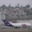

In [5]:
# let's view the image (its very small)
dataset_train[0]['img']

In [6]:
type(dataset_train[0]['img'])

PIL.PngImagePlugin.PngImageFile

In [7]:
len(dataset_train)

50000

In [8]:
# Testing Data
dataset_test = load_dataset(
                            "cifar10",
                             split="test",  # testing dataset
                             ignore_verifications=True  # set to true if seeing splits error
                             )
dataset_test

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2574: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

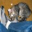

In [9]:
# let's view the image (its very small)
dataset_test[0]['img']

In [10]:
dataset_test[0]['label']

3

In [11]:
type(dataset_test[0]['img'])

PIL.PngImagePlugin.PngImageFile

In [12]:
len(dataset_test)

10000

Here we have specified that we want the training split of the dataset with split='train'. We return 50K images split across ten classes from this.

Most CNNs can only accept images of a fixed size. To handle this, we will reshape all images to 32x32 pixels using torchvision.transforms; a pipeline built for image preprocessing.

In [13]:
# Ensure that mean and std do not have zeros
mean = [0.485, 0.456, 0.406]  # Example values
std = [0.229, 0.224, 0.225]   # Example values

In [14]:
# image size
img_size = 32

#preprocess variable, to be used ahead
preprocess = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

The preprocess pipeline handles the height and width of our images but not the depth. Every image has a number of “color channels” that define its depth. For RGB images, there are three color channels; red, green, and blue, whereas grayscale images have just one.

Datasets commonly contain images with different color profiles, so we must convert them into a set format. We will use RGB, and as our images are all Python PIL objects, the color format is stored in an attribute called mode. The mode will be RGB for RGB images and L for grayscale images.

We perform the conversion to RGB and also perform the preprocess transformations like so:

In [15]:
from tqdm.auto import tqdm

inputs_train = []

for record in tqdm(dataset_train):
  img = record['img']
  label = record['label']

  # Convert from grayscale to RGB
  if img.mode == 'L':
    img = img.convert("RGB")

  #preprocessing
  input_tensor = preprocess(img)
  inputs_train.append([input_tensor,label])



  0%|          | 0/50000 [00:00<?, ?it/s]

In [16]:
print(len(inputs_train))
inputs_train[0][0].shape

50000


torch.Size([3, 32, 32])

In [17]:
print(inputs_train[0][1])

0


In [18]:
#inputs_train[0][1].shape  #label

In [19]:
inputs_train[0]

[tensor([[[ 0.9303,  0.9303,  0.9303,  ...,  0.7933,  0.7591,  0.7077],
          [ 0.9646,  0.9474,  0.9646,  ...,  0.8447,  0.8104,  0.7591],
          [ 0.9132,  0.9132,  0.9303,  ...,  0.8104,  0.7762,  0.7419],
          ...,
          [-0.1999, -0.1828, -0.1657,  ..., -0.4054, -0.4397, -0.3883],
          [-0.1999, -0.1999, -0.1828,  ..., -0.3712, -0.3712, -0.3712],
          [-0.3541, -0.4054, -0.3541,  ..., -0.5424, -0.5253, -0.5596]],
 
         [[ 1.0455,  1.0455,  1.0455,  ...,  0.9055,  0.8704,  0.8179],
          [ 1.0805,  1.0630,  1.0805,  ...,  0.9580,  0.9230,  0.8704],
          [ 1.0280,  1.0280,  1.0455,  ...,  0.9230,  0.8880,  0.8529],
          ...,
          [-0.1625, -0.1275, -0.1099,  ..., -0.3375, -0.3901, -0.3725],
          [-0.2500, -0.2325, -0.2325,  ..., -0.3725, -0.4076, -0.4251],
          [-0.3550, -0.4076, -0.3725,  ..., -0.5651, -0.5301, -0.5651]],
 
         [[ 1.4897,  1.4897,  1.4897,  ...,  1.3328,  1.2805,  1.2282],
          [ 1.5245,  1.5071,

In [20]:
inputs_train[12]

[tensor([[[ 0.4508,  0.5364,  0.6734,  ..., -0.0458,  0.1083,  0.2111],
          [ 0.8618,  0.9303,  0.7248,  ...,  0.2453,  0.2282,  0.2453],
          [ 1.1529,  1.2557,  1.1872,  ...,  0.0741,  0.0569,  0.0398],
          ...,
          [ 1.4440,  1.4269,  1.2899,  ...,  0.8789, -0.0801, -0.2856],
          [ 1.3413,  1.2385,  1.2043,  ...,  1.0159,  0.0912,  0.5193],
          [ 1.4954,  1.2899,  1.2385,  ...,  1.4612,  1.1529,  1.1529]],
 
         [[ 0.6604,  0.6779,  0.6078,  ..., -0.0399,  0.1001,  0.1702],
          [ 0.9230,  0.9755,  0.6954,  ...,  0.2577,  0.2227,  0.2402],
          [ 1.0805,  1.2031,  1.1681,  ...,  0.0826,  0.0651,  0.0476],
          ...,
          [ 0.9930,  0.8704,  0.7304,  ...,  0.6254, -0.3375, -0.5301],
          [ 0.7829,  0.6779,  0.6078,  ...,  0.7829, -0.1800,  0.2752],
          [ 1.2206,  1.0805,  0.9230,  ...,  1.3431,  1.0280,  1.0280]],
 
         [[ 0.6705,  0.6008,  0.3219,  ..., -0.5844, -0.2707, -0.0615],
          [ 0.9494,  0.9319,

Leaving us with 50,000 training examples, each a 3x32x32-dimensional tensor. The tensors are normalized to a [0,1][0,1] range by the transforms.ToTensor() step.

Right now, this normalization does not consider the pixel values of our overall set of images. Ideally, we should normalize by the mean and standard deviation values specific to this dataset.

In [21]:
import numpy as np

np.random.seed(0)

# calculate mean and std of images, first start by choosing a random
idx = np.random.randint(0,len(inputs_train),512)
idx.shape

(512,)

In [22]:
idx

array([ 2732, 43567, 42613, 45891, 21243, 30403, 32103, 41993, 20757,
       46884, 14935, 15430, 48600, 39512, 14650, 17089, 32230, 18983,
       43095, 24152, 35665, 16921, 27469, 38984,  6921, 38804,  2163,
        5072, 37619,  7877, 18430,  1871,  7599,  2496, 47954, 24675,
       42968, 31921, 33523,   797, 49811,  3219, 15246, 24999, 16321,
       19129, 41504, 49866, 18676, 31230, 11723, 43890, 17591, 43136,
       26752, 23605,  6021, 20006,  3560, 25332, 31055, 45444, 46522,
       47647, 21368, 20737, 28647, 26681, 14627, 12134, 47883, 41390,
       20571,  9781, 19340, 27257, 16298, 12372,  4420, 45830, 39876,
       17455, 14324, 38019,  7012,  9396, 47080,  3918,  9359, 44259,
       23482, 15127, 43727, 35725, 37237, 14165,  8752, 42565, 14505,
        5795, 23647, 40133, 28254, 41216, 36530, 25392, 16221, 18819,
       34402, 48682,   973, 20848, 10215, 11157, 24777, 13824,  2418,
       12843, 13242, 36223,  6521, 22626,  9123, 31454, 42947, 14254,
       23700, 37073,

In [23]:
# then we concatenate this subset of image tensors
tensors = torch.concat([inputs_train[i][0] for i in idx], axis=1)
tensors.shape

torch.Size([3, 16384, 32])

In [24]:
mean = torch.mean(tensors, axis=0)
mean

tensor([[2.1264, 2.1958, 2.1785,  ..., 1.4670, 1.4148, 1.2990],
        [2.1090, 2.2132, 2.2132,  ..., 1.4960, 1.4496, 1.3221],
        [2.1958, 2.2652, 2.2479,  ..., 1.5711, 1.5306, 1.4089],
        ...,
        [2.4392, 2.3756, 2.4335,  ..., 2.4392, 2.4392, 2.4392],
        [2.4392, 2.4218, 2.4102,  ..., 2.4392, 2.4392, 2.4392],
        [2.4392, 2.3871, 2.4045,  ..., 2.4045, 2.4045, 2.4045]])

In [25]:
std = torch.std(tensors, axis=0)
std

tensor([[0.1118, 0.1124, 0.1123,  ..., 0.1354, 0.1367, 0.1380],
        [0.1116, 0.1126, 0.1126,  ..., 0.1406, 0.1369, 0.1305],
        [0.1124, 0.1130, 0.1129,  ..., 0.1361, 0.1414, 0.1309],
        ...,
        [0.1958, 0.1949, 0.2042,  ..., 0.1958, 0.1958, 0.1958],
        [0.1958, 0.1956, 0.1872,  ..., 0.1958, 0.1958, 0.1958],
        [0.1958, 0.1953, 0.1955,  ..., 0.1955, 0.1955, 0.1955]])

In [26]:
del tensors

### **1. Importing Libraries**
```python
import numpy as np
```
This imports the NumPy library, which is a powerful library in Python used for numerical computations. It provides support for large multidimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.

### **2. Setting a Random Seed**
```python
np.random.seed(0)
```
- **Purpose**: Setting the seed ensures that the random numbers generated by NumPy are reproducible. This means every time you run this code, the same random numbers will be generated.
- **Why `0`?**: The number `0` is just an example seed value. Any integer can be used. It controls the starting point of the random number generation process.

### **3. Generating Random Indices**
```python
idx = np.random.randint(0, len(inputs_train), 512)
```
- **Purpose**: This line generates an array of random integers.
- **Parameters**:
  - `0`: The lower bound (inclusive) of the random numbers.
  - `len(inputs_train)`: The upper bound (exclusive) of the random numbers, which is the length of the `inputs_train` dataset.
  - `512`: The size of the output array, meaning we want 512 random integers.

- **What is `idx`?**:
  - **Structure**: `idx` is a 1-dimensional NumPy array containing 512 random integers.
  - **Purpose**: These integers are used as indices to randomly select a subset of images from the `inputs_train` dataset.

### **4. Concatenating Tensors**
```python
tensors = torch.concat([inputs_train[i][0] for i in idx], axis=1)
```
- **Purpose**: This line creates a single tensor by concatenating a subset of image tensors.
- **Breaking It Down**:
  - **List Comprehension**: `[inputs_train[i][0] for i in idx]`
    - This creates a list of tensors. For each index `i` in the `idx` array, it selects the `i`-th image from `inputs_train`.
    - **`inputs_train[i][0]`**:
      - `inputs_train[i]` selects the `i`-th element (likely a tuple or list) from the training dataset.
      - `[0]` selects the first element of this tuple/list, which is typically the image tensor.
  - **`torch.concat`**:
    - This is a method used to concatenate a list of tensors along a specified axis.
    - **`axis=1`**: Specifies that the tensors should be concatenated along the second axis (typically width for images).
  
- **What if `torch.concat` is not used?**:
  - If `torch.concat` is not used, you wouldn't be able to combine the selected tensors into a single large tensor. Instead, you'd have a list of separate tensors.

### **5. Calculating the Mean and Standard Deviation**
```python
mean = torch.mean(tensors, axis=0)
std = torch.std(tensors, axis=0)
```
- **Purpose**: These lines calculate the mean and standard deviation across the first axis of the concatenated tensor.
- **`torch.mean` and `torch.std`**:
  - **`tensors`**: The input tensor that was created by concatenating the images.
  - **`axis=0`**: Specifies that the mean and standard deviation should be computed along the first axis (which corresponds to the batch or number of concatenated images).
  - **Mean**: Provides the average pixel value across all the selected images for each pixel position.
  - **Standard Deviation**: Measures the amount of variation or dispersion of pixel values for each pixel position.

### **6. Deleting the Tensor**
```python
del tensors
```
- **Purpose**: This line deletes the `tensors` object to free up memory.
- **Why?**: The `tensors` object might take up a significant amount of memory. Deleting it when it's no longer needed helps prevent memory overloads, especially in environments with limited resources like Google Colab.

### **Summary**
- **`np.random.seed(0)`**: Ensures reproducibility of the random numbers.
- **`idx = np.random.randint(0, len(inputs_train), 512)`**: Creates an array of 512 random indices within the range of the dataset.
- **`tensors = torch.concat([...], axis=1)`**: Concatenates a random subset of image tensors into one large tensor along the specified axis.
- **`mean = torch.mean(tensors, axis=0)`**: Computes the mean across all images for each pixel position.
- **`std = torch.std(tensors, axis=0)`**: Computes the standard deviation across all images for each pixel position.
- **`del tensors`**: Frees up memory by deleting the large tensor.

This code snippet is essentially sampling a subset of images from the training set, concatenating them, and then calculating the mean and standard deviation of the pixels to normalize the data. The use of specific parameters and methods ensures that the process is efficient and manageable.

This normalization step is applied by another transformers.Compose step like so:

Normalization is a crucial step in the preprocessing pipeline for many machine learning models, particularly those involving neural networks, such as Convolutional Neural Networks (CNNs). Let's break down the code and explain why normalization is important.

### **1. Preprocessing Pipeline**
```python
preprocess = transforms.Compose([
    transforms.Normalize(mean=mean, std=std)
])
```
- **Purpose**: This defines a preprocessing pipeline using `transforms.Compose`, which allows you to chain multiple transformations together.
- **`transforms.Normalize(mean=mean, std=std)`**:
  - This transformation normalizes the tensor using the provided `mean` and `std` (standard deviation) values.
  - **Normalization Formula**:
    \[
    \text{normalized\_pixel} = \frac{\text{original\_pixel} - \text{mean}}{\text{std}}
    \]
  - **Parameters**:
    - **`mean`**: The mean pixel value across the dataset, calculated previously.
    - **`std`**: The standard deviation of pixel values across the dataset.
  - **Effect**: After normalization, the pixel values will be centered around 0 (since the mean is subtracted) and scaled so that they have a standard deviation of 1.

### **2. Normalizing the Training Data**
```python
for i in tqdm(range(len(inputs_train))):
    # preprocessing
    input_tensor = preprocess(inputs_train[i][0])
    # replace with normalized tensor
    inputs_train[i][0] = input_tensor
```
- **Purpose**: This loop applies the normalization transformation to each image tensor in the `inputs_train` list.

### **Understanding Normalization**

#### **Why Normalize?**
Normalization helps improve the training process of neural networks in several ways:

1. **Consistency Across Data**:
   - Pixel values in images typically range from 0 to 255. Without normalization, the input data would have large variations in scale, which can lead to inefficient learning.
   - By normalizing the data, you ensure that all input features (pixels) have a similar scale, making it easier for the network to learn.

2. **Improved Convergence**:
   - Neural networks often converge faster when the input data is centered around zero. This is because the gradients of the loss function are more consistent, reducing the chance of getting stuck in local minima.

3. **Reduced Internal Covariate Shift**:
   - During training, the distribution of each layer's inputs changes as the parameters of the previous layers change. Normalization helps mitigate this effect, known as internal covariate shift, leading to more stable training.

#### **How Does Normalization Work?**
- **Mean**: Subtracting the mean centers the data around zero, which is important because many activation functions (like ReLU or tanh) work better when their inputs are centered around zero.
- **Standard Deviation**: Dividing by the standard deviation scales the data so that it has unit variance, which helps in stabilizing the gradients during training.

### **3. Replacing the Original Tensors**
```python
inputs_train[i][0] = input_tensor
```
- **Purpose**: After normalizing the tensor, this line replaces the original (non-normalized) tensor with the normalized version in the `inputs_train` list.

### **Summary**
- **Normalization**: It's a preprocessing step to ensure that all image data has similar scale and mean, which is crucial for efficient and effective training of neural networks.
- **Why It's Important**: Normalization leads to faster convergence, better model performance, and more stable training by ensuring that the data fed into the network has a mean of 0 and a standard deviation of 1.
- **Code Functionality**: The code is applying this normalization transformation to each image tensor in your training data, replacing the original images with their normalized versions.

We repeat the steps above for a test set that we will use for validating our CNN classifier performance. The validation set is also downloaded from Hugging Face datasets via load_dataset by switching the earlier split parameter to 'test':

In [27]:
dataset_val = load_dataset(
    'cifar10',
    split='test',  # test set (used as validation set)
    ignore_verifications=False  # set to True if seeing splits Error
)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2574: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


The validation set must also be preprocessed, find the code for it here.

Both train and validation splits are added into DataLoader objects. The data loaders shuffle, batch, and load data into the model during training or inference (validation).

In [28]:
from tqdm.auto import tqdm

inputs_val = []
i = 0
for record in tqdm(dataset_val):
    image = record['img']
    label = record['label']

    # convert from grayscale to RBG
    if image.mode == 'L':
        image = image.convert("RGB")

    # prepocessing
    input_tensor_val = preprocess(image)
    inputs_val.append((input_tensor_val, label)) # append to batch list

  0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
batch_size = 64

# add to dataloaders
dloader_train = torch.utils.data.DataLoader(
  	inputs_train,
    batch_size=batch_size,
    shuffle=True
)

dloader_val = torch.utils.data.DataLoader(
  	inputs_val,
    batch_size=batch_size,
    shuffle=False
)

# Normalization for Channel 3 (RGB): Essential due to the variability in pixel values across channels, which helps models learn more effectively.
# Normalization for Channel 1 (Grayscale): Less critical for simple datasets like MNIST, where the model can still perform well without it due to the uniformity of the data and the simpler task.

**CNN Construction
We can start building our CNN by creating a ConvNeuralNet class that will contain all our network layers and define the order of transformations through the network. The network will look like this:**

In [30]:
# creating a CNN class
class ConvNeuralNet(nn.Module):
	  #  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        self.fc6 = nn.Linear(1024, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(256, num_classes)

    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)

        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.fc8(out)  # final logits
        return out

### **Understanding CNN Layers**

1. **`nn.Conv2d` (Convolutional Layer)**:
   - **Purpose**: This layer applies a convolution operation to the input, which helps in feature extraction. It detects patterns such as edges, textures, or other features in the image.
   - **Parameters**:
     - `in_channels`: Number of input channels (e.g., 3 for RGB images, 1 for grayscale).
     - `out_channels`: Number of output channels (i.e., the number of filters).
     - `kernel_size`: Size of the filter (e.g., 3x3 or 4x4).
     - `padding`: Padding added to the input image to control the spatial dimensions.

2. **`nn.ReLU` (Rectified Linear Unit)**:
   - **Purpose**: Applies a non-linear activation function, which introduces non-linearity into the network. This helps the network learn more complex patterns.
   - **Usage**: Often used after convolutional layers to introduce non-linearity.

3. **`nn.MaxPool2d` (Max Pooling Layer)**:
   - **Purpose**: Reduces the spatial dimensions of the feature maps (width and height) while retaining the most important features. This helps in reducing computation and controlling overfitting.
   - **Parameters**:
     - `kernel_size`: Size of the pooling window.
     - `stride`: The step size with which the pooling window moves.

### **Typical Layer Combinations**

1. **Convolutional Layer + Activation Function**:
   - **Example**: `Conv2d` followed by `ReLU`.
   - **Purpose**: Detect features and then apply a non-linearity. This is a common pattern to build feature extraction layers.

2. **Convolutional Layer + Activation Function + Pooling Layer**:
   - **Example**: `Conv2d`, `ReLU`, followed by `MaxPool2d`.
   - **Purpose**: Extract features, introduce non-linearity, and then reduce spatial dimensions. This combination is often used to progressively reduce the spatial dimensions while increasing the number of feature channels.

3. **Convolutional Layer + Pooling Layer**:
   - **Less Common**: Using a convolutional layer directly followed by pooling is less common but can be used in specific architectures.

### **Deciding When to Use Which Layers**

1. **Feature Extraction**:
   - **Use `Conv2d` + `ReLU`**: When you want to extract features and add non-linearity. Typically, every convolutional layer is followed by a non-linear activation like ReLU.

2. **Dimensionality Reduction**:
   - **Add `MaxPool2d`**: After several convolutional layers, adding a pooling layer helps reduce the spatial dimensions of the feature maps, which can be useful for reducing computational load and avoiding overfitting.

3. **Building Blocks**:
   - **Convolutional Layers**: Typically, you stack multiple convolutional layers followed by activation functions.
   - **Pooling Layers**: Used intermittently to reduce dimensions, usually after a few convolutional layers.

### **Example of Layer Combination**

Here's a common pattern for a CNN block:

```python
class ExampleBlock(nn.Module):
    def __init__(self):
        super(ExampleBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        return x
```

### **How to Decide on Layer Combinations**

- **Experimentation**: In practice, the specific combination of layers and their parameters often comes down to experimentation and tuning based on the dataset and problem you are addressing.
  
- **Architectural Principles**: Follow established architectural principles from successful models like AlexNet, VGG, ResNet, etc. These models have well-defined patterns for layer combinations that have been proven effective.

### **Summary**

- **`Conv2d`**: For feature extraction.
- **`ReLU`**: To introduce non-linearity.
- **`MaxPool2d`**: To reduce spatial dimensions and retain essential features.

By understanding the purpose of each layer and experimenting with different combinations, you can design effective CNN architectures for various tasks.